In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from skimage.data import imread
from skimage.measure import label, regionprops

%matplotlib inline

In [3]:
# set path
DATA_DIR = 'Z:/input/201809_airbus_ship_detection/'

TRAIN_IMG_DIR = 'Z:/input/201809_airbus_ship_detection/train/'
TEST_IMG_DIR = 'Z:/input/201809_airbus_ship_detection/test/'

## Utilities
___
TODO: Move the functions to utils.py

In [3]:
train = pd.read_csv(DATA_DIR + 'train_ship_segmentations.csv')
train.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
2  00021ddc3.jpg  101361 1 102128 3 102896 4 103663 6 104430 9 1...
3  00021ddc3.jpg  95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4  00021ddc3.jpg  74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...

## Run-Length Encoded Pixels
____
We have run-length encoded pixels (rle) in the data. 

We will need to decode the EncodedPixels.

From competition overview: 
    
    The competition format requires a space delimited list of pairs. For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask. The pixels are one-indexed and numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc. A prediction of of "no ship in image" should have a blank value in the EncodedPixels column.

ImageId:  000155de5.jpg
Encoded Pixels:  264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33

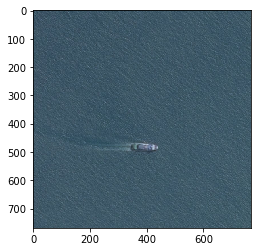

In [4]:
# example
encoded_pixels = train.loc[1]['EncodedPixels']
imageId = train.loc[1]['ImageId']
img = imread(TRAIN_IMG_DIR + '/' + imageId)

print('ImageId: ', imageId)
print('Encoded Pixels: ', encoded_pixels)
print('Image Shape: ', img.shape)
plt.imshow(img)

splited encoded pixels: 
 ['264661', '17', '265429', '33', '266197', '33', '266965', '33']
start point extracted: 
 [array(264661), array(265429), array(266197), array(266965)]
length extracted: 
 [array(17), array(33), array(33), array(33), array(33)]
end point calculated: 
 [264678, 265462, 266230, 266998, 267766]
reshaped mask:
 [[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


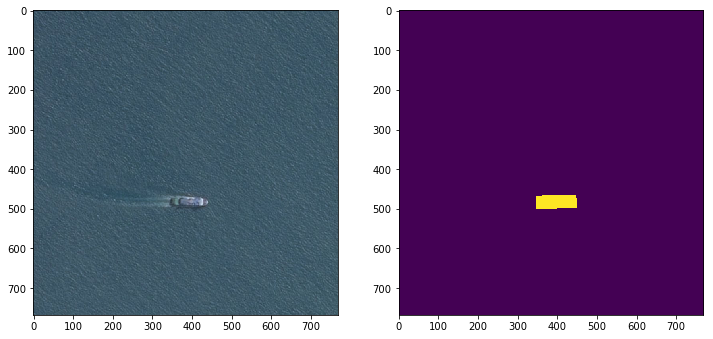

In [5]:
# convert encoded pixels to rle

shape = img.shape

# first recreate the shape of the image into row
mask = np.zeros(shape[0] * shape[1], dtype=np.uint8) # uint8 has output range: 0 to 255 / Output type: Unsigned 8-bit integer / Bytes per Element: 1

# split the encoded pixels / is in string form
s = encoded_pixels.split() 
print('splited encoded pixels: \n', s[:8])

# get start point - choose every second from position 0 / make it into integer
start = [np.asarray(x, dtype=int) for x in s[0:][::2]] 

print('start point extracted: \n', start[:4])

# get length - choose every second from position 1 / make it into integer
length =  [np.asarray(x, dtype=int) for x in s[1:][::2] ]
print('length extracted: \n', length[:5])

# calculate end point - start + length
end = [x + y for x, y in zip(start, length)]
print('end point calculated: \n', end[:5])

# make every values in between start and end = 1
for x, y in zip(start, end):
    # subtract 1, because while shape starts from position 0, encoded pixel starts from 1. 
    mask[x - 1:y - 1] = 1

# reshape the mask. Transpose for correct direction
mask = mask.reshape(shape[0], shape[1]).T
print('reshaped mask:\n', mask)

# let's see images to see if it worked 
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(img)
ax[1].imshow(mask)

That worked well. Above process will become **encoded_pixel_to_mask()** function in utils.py.

In [6]:
# TO-DO Move this function to utils.py &&& and shorten
def encoded_pixel_to_mask(encoded_pixels, shape=(768, 768)):
    # first recreate the shape of the image into row
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8) # uint8 has output range: 0 to 255 / Output type: Unsigned 8-bit integer / Bytes per Element: 1
   
    # split the encoded pixels / is in string form
    s = encoded_pixels.split() 

    # get start point - choose every second from position 0 / make it into integer
    # get length - choose every second from position 1 / make it into integer
    start, length = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])] 

    # calculate end point - start + length
    end = [x + y for x, y in zip(start, length)]

    # make every values in between start and end = 1
    for x, y in zip(start, end):
        mask[x:y] = 1

    # reshape the mask. Transpose for correct direction
    mask = mask.reshape(shape[0], shape[1]).T
    
    return mask

def join_encoded_pixel(imageId):
    # there are many images with multiple ships.
    # join encoded pixels of these ships.
    
    # could be single or multiple rows of encoded pixels
    encoded = train[train.ImageId == imageId]['EncodedPixels']
    
    # join rows and return
    return ' '.join(encoded.fillna('').astype(str))

## Number of Ships per Image
___

Number of images with 0.0 ships is: 75000 (57.24%)
Number of images with 1.0 ships is: 18525 (14.14%)
Number of images with 2.0 ships is: 10464 (7.99%)
Number of images with 3.0 ships is: 6096 (4.65%)
Number of images with 4.0 ships is: 4316 (3.29%)
Number of images with 5.0 ships is: 3045 (2.32%)
Number of images with 6.0 ships is: 2718 (2.07%)
Number of images with 7.0 ships is: 1911 (1.46%)
Number of images with 8.0 ships is: 1784 (1.36%)
Number of images with 9.0 ships is: 1557 (1.19%)
Number of images with 10.0 ships is: 1210 (0.92%)
Number of images with 11.0 ships is: 1089 (0.83%)
Number of images with 12.0 ships is: 1116 (0.85%)
Number of images with 13.0 ships is: 767 (0.59%)
Number of images with 14.0 ships is: 742 (0.57%)
Number of images with 15.0 ships is: 690 (0.53%)


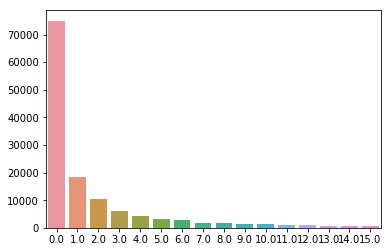

In [7]:
"""
Each row represents a ship.
Count the number of ships per image by grouping.
Replace missing value with 0.
Graph
"""
train['num_of_ships'] = train[~train.EncodedPixels.isna()].groupby('ImageId')['ImageId'].transform('count')
train['num_of_ships'] = train['num_of_ships'].fillna(0)

# get values of unique numbers and frequencies
values, count = np.unique(train['num_of_ships'], return_counts=True)
sns.barplot(x=values, y=count)

# print distribution
for i in range(0, len(values)):
    print('Number of images with {} ships is: {} ({}%)'.format(values[i], count[i], round(count[i]/len(train) * 100, 2)))

## Images
___
### Images with ships

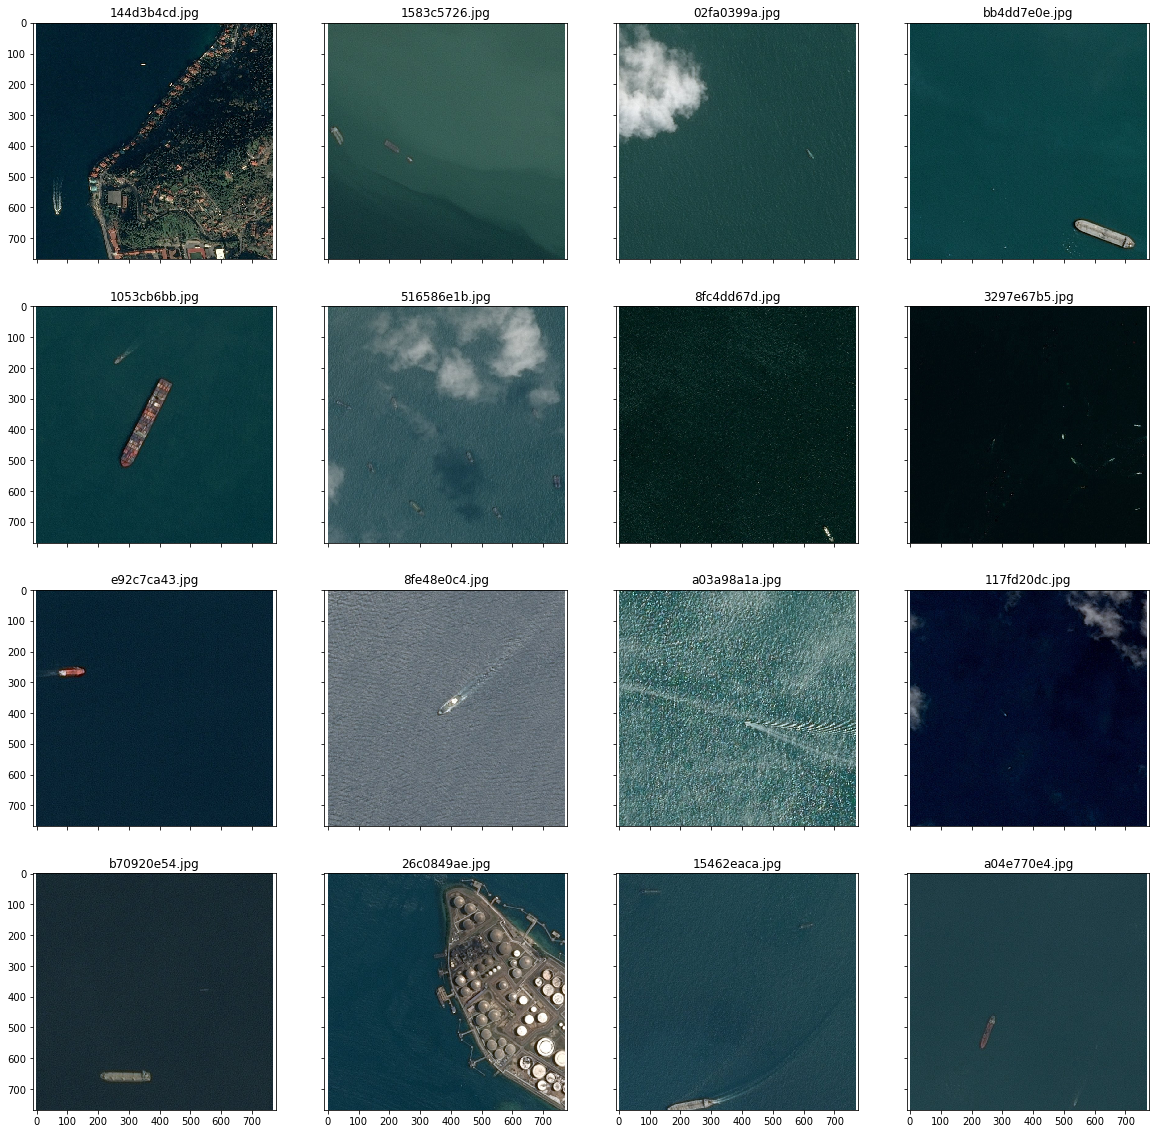

In [8]:
sample = train[~train.EncodedPixels.isna()].sample(16)

fig, ax = plt.subplots(4, 4, sharex='col', sharey='row')
fig.set_size_inches(20, 20)

for i, imgid in enumerate(sample.ImageId):
    col = i % 4
    row = i // 4
    
    path = TRAIN_IMG_DIR + imgid
    img = imread(path)
    
    ax[row, col].imshow(img)
    ax[row, col].set_title(imgid)

It's very interesting, because while some of these ships are visible to human eyes, some of these ships are difficult to track with naked eye! (for example, 

I want to see how they are masked in the data

### Images with mask on ships

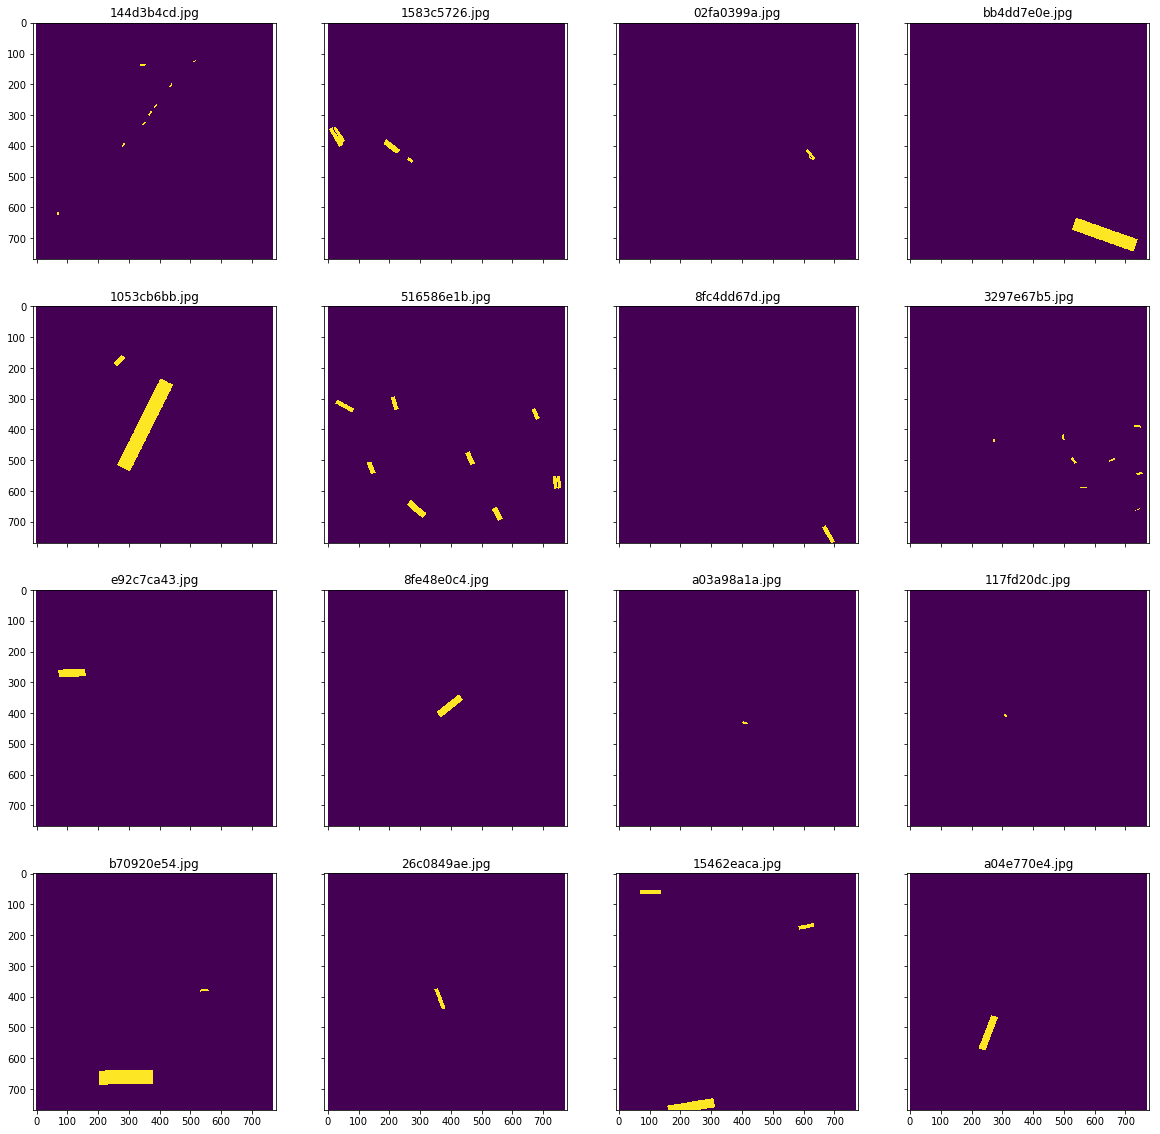

In [9]:
fig, ax = plt.subplots(4, 4, sharex='col', sharey='row')
fig.set_size_inches(20, 20)

for i, imgid in enumerate(sample.ImageId):
    col = i % 4
    row = i // 4
    
    mask = encoded_pixel_to_mask(join_encoded_pixel(imgid))
    
    ax[row, col].imshow(mask)
    ax[row, col].set_title(imgid)

## Methodology
___
In this project, I think there are two different ways to approach the problem. 

First is using **object segmentation** to locate the ships.

Advantages: 
- relatively easy training, I presume. I could use pretrained data or pretrain the data we have with part of train_set to achieve higher accuracy. 
Disadvantages:
- I will need to devise a way to seperate ships after the prediction to submit. Especially difficult because there could be multiple ships overlapping.

Second way is **object detection**.
Advantages:
- no need to separate ships. Also it looks like (from observing the dataset), competition providers have used object detection to predict ships location. 
- I'm more familiar with object detection than image segmentation :D
Disadvantages: 
- I'm not entirely sure how to make a mask into bounding box. It's probably doable tho?

To start, I think I'll try using **object detection**, because I really enjoy object detection. 

So, to do so, we need start by drawing bounding boxes around these ships.

## Masks to Bounding Boxes
___

ImageId:  000155de5.jpg
Encoded Pixels:  264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33

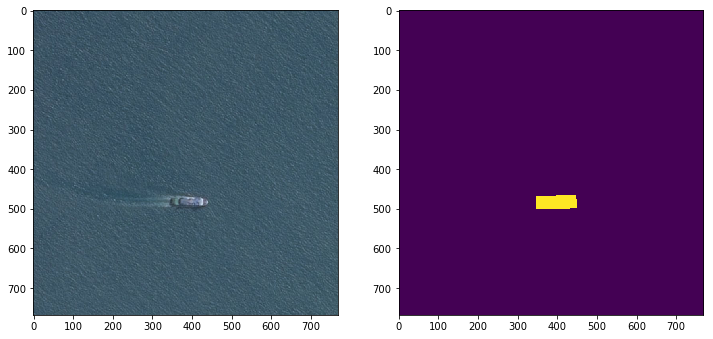

In [10]:
# example
encoded_pixels = train.loc[1]['EncodedPixels']
imageId = train.loc[1]['ImageId']
img = imread(TRAIN_IMG_DIR + '/' + imageId)

print('ImageId: ', imageId)
print('Encoded Pixels: ', encoded_pixels)
print('Image Shape: ', img.shape)

# let's see images to see if it worked 
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].imshow(img)
ax[1].imshow(encoded_pixel_to_mask(join_encoded_pixel(imageId)))

Credits to [Costas Voglis's kernal](https://www.kaggle.com/voglinio/from-masks-to-bounding-boxes). I used his kernal as reference. 

found bbox (466, 344, 502, 448)


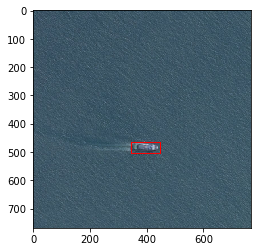

In [11]:
# Create figure and axes
fig,ax = plt.subplots(1)

image_with_box = img.copy()

# encoded pixels to mask
mask = encoded_pixel_to_mask(encoded_pixels)

# skimage.measure.label connects adjacent pixels and labels the region. 
labeled_mask = label(mask) 

# skimage.measure.regionprops measures properties of labeled image region.
properties = regionprops(labeled_mask)

for x in properties:
    # properties.bbox will return -> (min_row, min_col, max_row, max_col)
    print('found bbox', x.bbox)
    
    # draw rectangle Rectangle((x, y), width, height) -> sooo ((min_col, min_row), max_col - min_col, max_row - min_row) -> would do the trick.
    rect = patches.Rectangle((x.bbox[1], x.bbox[0]), x.bbox[3] - x.bbox[1], x.bbox[2] - x.bbox[0], linewidth=1,edgecolor='r',facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect)

# add the patch to img and show image!
ax.add_patch(rect)
ax.imshow(image_with_box)

Nice, make it into a function and draw

### Images with bounding box on ship

In [12]:
# Encoded Pixels to bounding box. 
def encoded_pixels_to_bounding_box(ep):
    # encoded pixels to mask
    # skimage.measure.label connects adjacent pixels and labels the region.
    # skimage.measure.regionprops measures properties of labeled image region.
    properties = regionprops(label(encoded_pixel_to_mask(ep))) 
    for x in properties:
        # properties.bbox will return -> (min_row, min_col, max_row, max_col)
        # return in order of (min_col, min_row, max_col, max_row) => (xmin ymin xmax ymax)
        return (x.bbox[1], x.bbox[0],x.bbox[3], x.bbox[2])

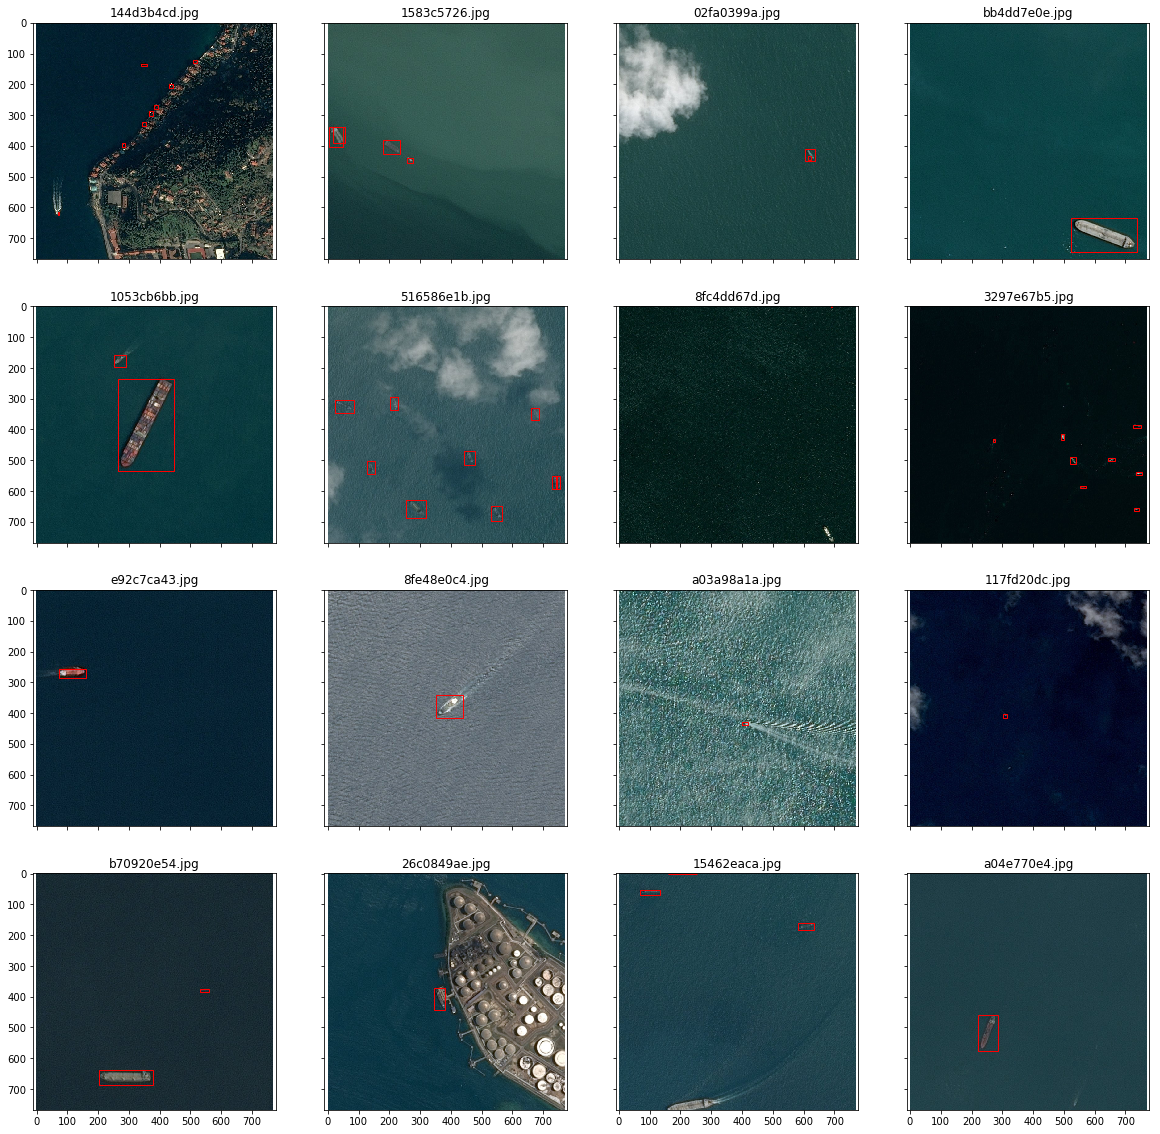

In [13]:
# let's see this!
fig, ax = plt.subplots(4, 4, sharex='col', sharey='row')
fig.set_size_inches(20, 20)

for i, imgid in enumerate(sample.ImageId):
    col = i % 4
    row = i // 4
    
    img = imread(TRAIN_IMG_DIR + '/' + imgid)

    encoded_pixels = train[train.ImageId == imgid]['EncodedPixels']
    for ship in encoded_pixels:
        bbox = encoded_pixels_to_bounding_box(ship)
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1,edgecolor='r',facecolor='none')
        ax[row, col].add_patch(rect)

    ax[row, col].imshow(img)
    ax[row, col].set_title(imgid)

# GREAT!

## Create bbox column and save the csv

In [14]:
############### WARNING: THIS PROCESS TAKES A WHILE ############################\
train['bbox'] = train[~train.EncodedPixels.isna()].apply(lambda x: encoded_pixels_to_bounding_box(x['EncodedPixels']), axis = 1)
train['xmin'] = train[~train.bbox.isna()].apply(lambda x: x['bbox'][0], axis=1)
train['ymin'] = train[~train.bbox.isna()].apply(lambda x: x['bbox'][1], axis=1)
train['xmax'] = train[~train.bbox.isna()].apply(lambda x: x['bbox'][2], axis=1)
train['ymax'] = train[~train.bbox.isna()].apply(lambda x: x['bbox'][3], axis=1)

In [15]:
train.to_csv(DATA_DIR + 'train_ship_bbox.csv', )